# <center>COMPUTER VISION - LENET MODEL</center>
***
## <font color = blue>I. DATA PREPARATION</font>
> A. LIBRARIES<br>
> B. CONSTANTS<br>
> C. COLLECTING DATA AND CREATING DICTIONARIES<br>
> D. SPLIT BETWEEN TRAINING SET AND TEST SET<br>
> E. DATA PREPARATION WITH PREPROCESSING<br>

## <font color = blue>II. CALL BACKS</font>
> A. AUTOMATIC REDUCTION OF THE LEARNING RATE<br>
> B. EARLY STOPPING<br>

## <font color = blue>III. LENET MODEL</font>
> A. CREATION OF LENET MODEL<br>
> B. COMPILING AND TRAINING<br>
> C. TRAINING HISTORY<br>
> D. CONFUSION MATRIX<br>
> E. CLASSIFICATION REPORT<br>
***
##### Additional information before to get started :
* Resolution choosen for the tests : (28, 28, 1).
* The Lenet model is well known and working efficiently for MNIST dataset (MNIST images are 28 × 28 pixels).

##### Laptop specification :
* OS: Windows 11
* Processor: AMD Ryzen 7 5800HS with Radeon Graphics 3.20 GHz
* Installed RAM: 16,0 GB
* GPU: NVIDIA GetForce RTX3080 8GB
***

## <font color = blue>I. DATA PREPARATION</font>
> A. LIBRARIES

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from time import time

from helpers import load_image
from helpers import show_wrong_predictions

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
import itertools

import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

> B. CONSTANTS

In [2]:
BATCH_SIZE       = 32                # Bacth size for dataset
TARGET_SIZE      = (28, 28)        # Resolution of images before training
CHANNELS         = 1                 # Number of channels (1 => grey, 3 => color) 
INPUT_SHAPE      = (28, 28, 1)     # Resolution of images with channels before training
IMAGES_DIRECTORY = '../data/final/'  # Directory where are located images

SAVED_WEIGHTS    = './model/model_LENET.h5'  # File name where are saved the final weights of the model

preprocess_input = lambda x : x / 255

> C. COLLECTING DATA AND CREATING DICTIONARIES

In [3]:
df = pd.read_csv('../data/data_with_meta.csv')
df.head()

,Unnamed: 0,filename,url,description,type,filepath,scraped,old_filename,old_filepath,height,width,channels,landscape
0,0,img_0000000.jpg,https://templates.invoicehome.com/modele-factu...,100 modèles gratuits de factures | Téléchargem...,facture,./final/img_0000000.jpg,1,img_0000000.jpg,./facture/img_0000000.jpg,1061.0,750.0,3.0,0.0
1,1,img_0000001.jpg,https://templates.invoicehome.com/modele-factu...,100 modèles gratuits de factures | Téléchargem...,facture,./final/img_0000001.jpg,1,img_0000001.jpg,./facture/img_0000001.jpg,1061.0,750.0,3.0,0.0
2,2,img_0000002.jpg,https://www.coover.fr/wp-content/uploads/2021/...,Facture proforma : modèle à télécharger gratui...,facture,./final/img_0000002.jpg,1,img_0000002.jpg,./facture/img_0000002.jpg,1024.0,726.0,3.0,0.0
3,3,img_0000003.jpg,https://templates.invoicehome.com/modele-factu...,100 modèles gratuits de factures | Téléchargem...,facture,./final/img_0000003.jpg,1,img_0000003.jpg,./facture/img_0000003.jpg,1061.0,750.0,3.0,0.0
4,4,img_0000004.jpg,https://files.intum.com/v/vosfactures/files/31...,Base de Connaissances - Vos Factures - Créer u...,facture,./final/img_0000004.jpg,1,img_0000004.jpg,./facture/img_0000004.jpg,771.0,773.0,3.0,1.0


In [4]:
# Creating dictionary
dico_type = {'facture': 0,
             'id_pieces': 1,
             'justif_domicile': 2,
             'passeport': 3,
             'paye': 4,
             'carte postale': 5,
             'form': 6,
             'scientific_publication': 7,
             'advertisement': 8,
             'letter': 9,
             'resume': 10,
             'specification': 11,
             'handwritten': 12,
             'memo': 13,
             'invoice': 14,
             'budget': 15,
             'news_article': 16,
             'presentation': 17,
             'file_folder': 18,
             'scientific_report': 19,
             'email': 20,
             'questionnaire': 21}

# Creating revert dictionary
dico_type_inv = {v: k for k, v in dico_type.items()}

# Convert types according to the dictionary
df['type_num'] = df.type.replace(dico_type)

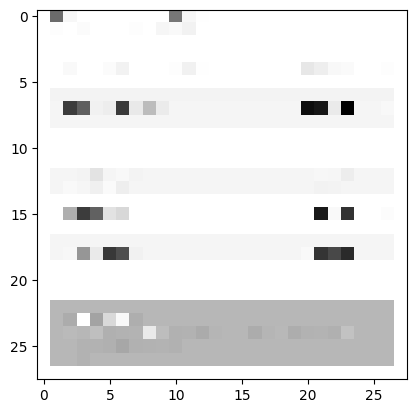

In [5]:
# Display a document randomly
num_alea = np.random.randint(len(df))

plt.imshow(load_image(directory = IMAGES_DIRECTORY,
                      filename = df.filename[num_alea],
                      channels = CHANNELS,
                      size = TARGET_SIZE,
                      preprocess = preprocess_input),
          cmap = 'gray');


> D. SPLIT BETWEEN TRAINING SET AND TEST SET

In [6]:
from sklearn.model_selection import train_test_split
X_train_path, X_test_path, y_train, y_test = train_test_split(df.filename, df.type_num,
                                                              test_size = 0.2, random_state = 1234)

> E. DATA PREPARATION WITH PREPROCESSING

In [7]:
# Training dataset creation
dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))
dataset_train = dataset_train.map(lambda x, y : [load_image(directory = IMAGES_DIRECTORY,
                                                            filename = x,
                                                            channels = CHANNELS,
                                                            size = TARGET_SIZE,
                                                            preprocess = preprocess_input), y],
                                  num_parallel_calls = -1)  # loading in multi-tasking

# Group by batch
dataset_train = dataset_train.batch(batch_size = BATCH_SIZE)


# Test dataset creation
dataset_test = tf.data.Dataset.from_tensor_slices((X_test_path, y_test))
dataset_test = dataset_test.map(lambda x, y : [load_image(directory = IMAGES_DIRECTORY,
                                                          filename = x,
                                                          channels = CHANNELS,
                                                          size = TARGET_SIZE,
                                                          preprocess = preprocess_input), y],
                                  num_parallel_calls = -1)  # loading in multi-tasking

# Group by batch
dataset_test = dataset_test.batch(batch_size = BATCH_SIZE)

C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [8]:
# Shape of one lot of dataset
X_t, y_t = next(iter(dataset_train))
print('Shape of the batch X_t :', X_t.shape)
print('Target elements of the batch :', y_t.numpy(), '\n')

Shape of the batch X_t : (32, 28, 28, 1)
Target elements of the batch : [ 5 21  5  4  1  6  4  5  1  0  4  9  3  1  1  3  2  5  1  1  4  5  5  5
  1  5  4  9 20  4  4  3] 



## <font color = blue>II. CALL BACKS</font>
> A. AUTOMATIC REDUCTION OF THE LEARNING RATE

In [9]:
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',                # Metric to control
                                         patience = 3,                        # Number of epochs to wait before decreasing the learning rate
                                         factor = 0.1,
                                         verbose = 2,                         # Number of informations displayed during training
                                         mode = 'min')                        # Indicate the metric decrease

> B. EARLY STOPPING

In [10]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',          # Metric to control
                                         patience = 10,                 # Number of epochs to wait before stopping the training
                                         mode = 'min',                  # Indicate the metric decrease
                                         restore_best_weights = True)   # To restore the weights of the best epoch

## <font color = blue>III. LENET MODEL</font>
> A. CREATION OF LENET MODEL

In [11]:
lenet = tf.keras.Sequential()
lenet.add(Conv2D(filters = 30, input_shape = INPUT_SHAPE, kernel_size = (5, 5), activation = 'relu'))
lenet.add(MaxPooling2D(pool_size = (2, 2)))
lenet.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu'))
lenet.add(MaxPooling2D(pool_size = (2, 2)))
lenet.add(Flatten())
lenet.add(Dropout(rate = 0.2))
lenet.add(Dense(units = 128, activation = 'relu'))
lenet.add(Dense(units = 22, activation = 'softmax'))

lenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 30)        780       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        4336      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dropout (Dropout)           (None, 400)               0

> B. COMPILING AND TRAINING

In [12]:
lenet.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),  # loss function
              optimizer = tf.keras.optimizers.Adam(),                  # optimizer algorithm
              metrics = ['accuracy'])                                  # metric

In [13]:
# Initialization of a timer
from time import time
t0 = time()

history = lenet.fit(dataset_train,                             # Training dataset
                    epochs = 50,                               # Number of epoch
                    validation_data = dataset_test,            # Test dataset
                    callbacks = [lr_plateau, early_stopping],  # Callbacks
                    workers = -1)                              # Using all processors

# Calulation of training time
t1 = time() - t0
print("Training time in {} minutes".format(t1 // 60))

Epoch 1/50
33/33 [==============================] - 3s 27ms/step - loss: 2.8803 - accuracy: 0.1673 - val_loss: 2.9161 - val_accuracy: 0.0992 - lr: 0.0010
Epoch 2/50
33/33 [==============================] - 1s 27ms/step - loss: 2.7655 - accuracy: 0.1845 - val_loss: 2.9224 - val_accuracy: 0.1221 - lr: 0.0010
Epoch 3/50
33/33 [==============================] - 1s 26ms/step - loss: 2.7210 - accuracy: 0.1759 - val_loss: 2.8392 - val_accuracy: 0.1641 - lr: 0.0010
Epoch 4/50
33/33 [==============================] - 1s 23ms/step - loss: 2.6499 - accuracy: 0.2141 - val_loss: 2.7622 - val_accuracy: 0.2214 - lr: 0.0010
Epoch 5/50
33/33 [==============================] - 1s 22ms/step - loss: 2.5143 - accuracy: 0.2419 - val_loss: 2.6241 - val_accuracy: 0.2328 - lr: 0.0010
Epoch 6/50
33/33 [==============================] - 1s 23ms/step - loss: 2.3971 - accuracy: 0.2725 - val_loss: 2.5466 - val_accuracy: 0.2405 - lr: 0.0010
Epoch 7/50
33/33 [==============================] - 1s 23ms/step - loss: 2.2

> C. TRAINING HISTORY

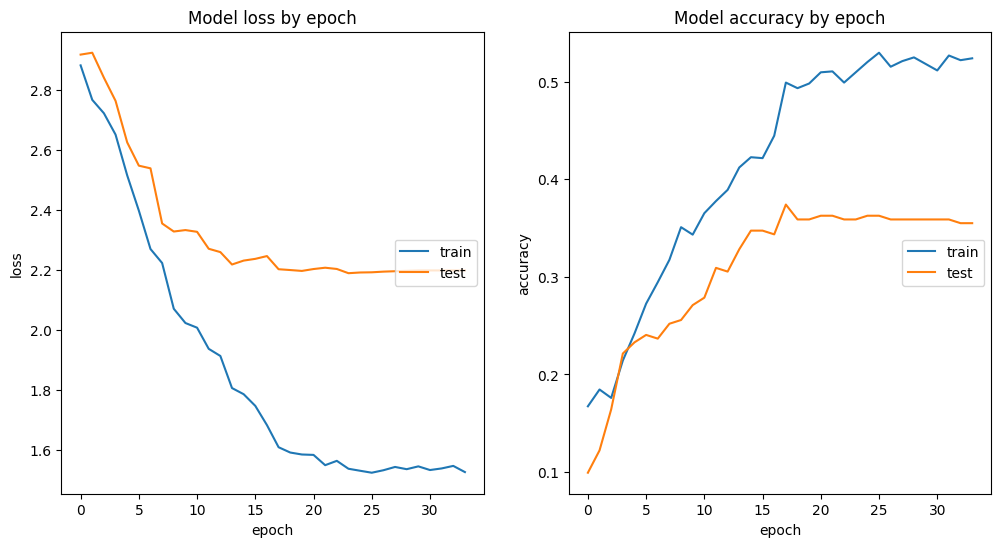

In [14]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

> D. CONFUSION MATRIX

In [15]:
####### PREDICTIONS #######
X_test = [load_image(directory = IMAGES_DIRECTORY,
                                 filename = x,
                                 channels = 1,
                                 size = TARGET_SIZE,
                                 preprocess = preprocess_input) for x in X_test_path]
y_prob = [lenet.predict(np.array([x], dtype=np.float32))[0] for x in X_test]

# Class predictions
y_pred = tf.argmax(y_prob, axis = -1).numpy()

1/1 [==============================] - 0s 16ms/step


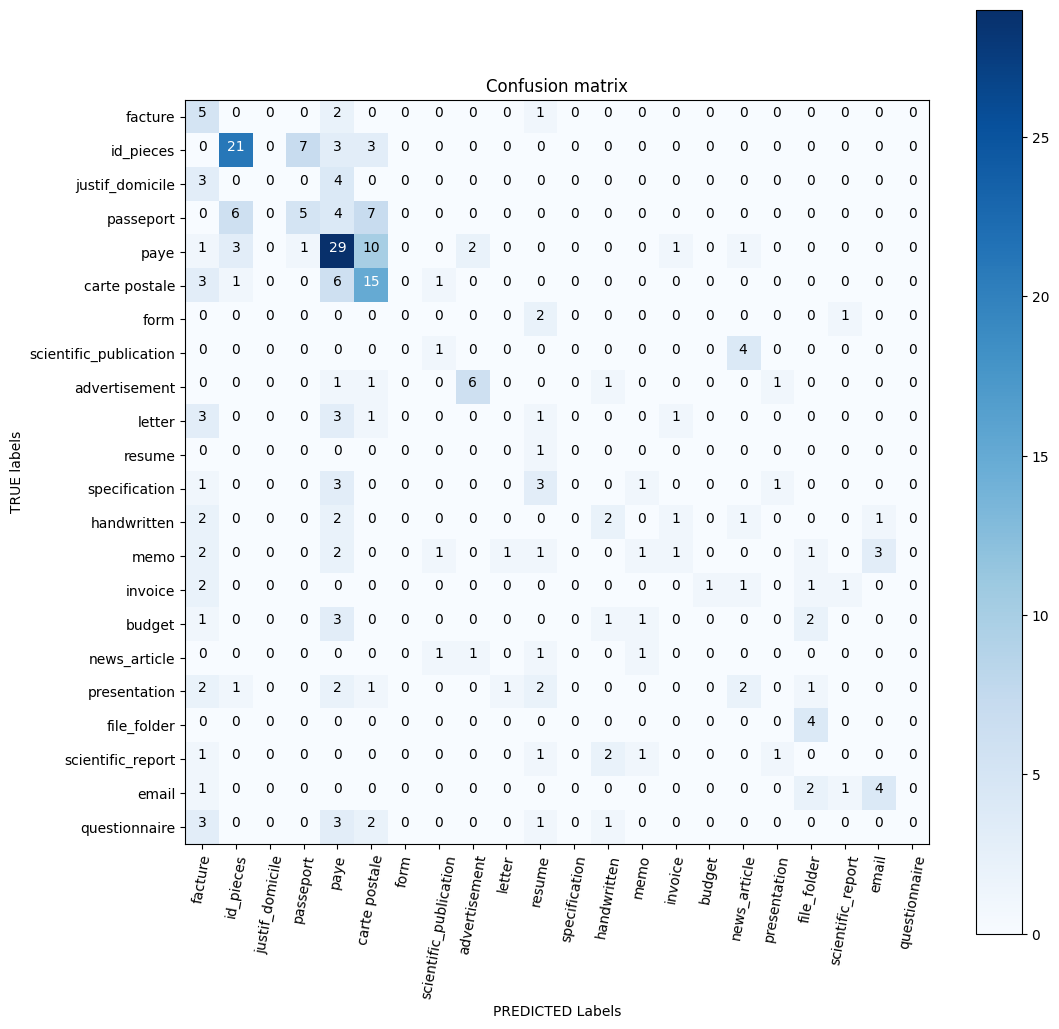

In [16]:
cnf_matrix = confusion_matrix(y_test, y_pred)

classes = dico_type
plt.figure(figsize = (12, 12))

plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 80)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('TRUE labels')
plt.xlabel('PREDICTED Labels')
plt.show()

> E. CLASSIFICATION REPORT

In [17]:
# Class predictions with type (passport, resume, etc...)
y_pred_type = pd.DataFrame(y_pred).replace(dico_type_inv)

# True class with type (passport, resume, etc...)
y_test_type = y_test.replace(dico_type_inv)

print( classification_report(y_test_type, y_pred_type) )

                        precision    recall  f1-score   support

         advertisement       0.67      0.60      0.63        10
                budget       0.00      0.00      0.00         8
         carte postale       0.38      0.58      0.45        26
                 email       0.50      0.50      0.50         8
               facture       0.17      0.62      0.26         8
           file_folder       0.36      1.00      0.53         4
                  form       0.00      0.00      0.00         3
           handwritten       0.29      0.22      0.25         9
             id_pieces       0.66      0.62      0.64        34
               invoice       0.00      0.00      0.00         6
       justif_domicile       0.00      0.00      0.00         7
                letter       0.00      0.00      0.00         9
                  memo       0.20      0.08      0.11        13
          news_article       0.00      0.00      0.00         4
             passeport       0.38      

C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## The model LENET, too basic, does not provide interesting results. Therefore, next step will be to use pre-trained models.